<a href="https://colab.research.google.com/github/JohatTech/Pneumonia-Detection-with-CNN-arquitecture-with-Tensorflwo/blob/main/Pneumonia_CNN_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pneumonia detection with CNN 

In [ ]:
#importing fundamental libraries 
import numpy as np
import tensorflow as tf
import keras
import pandas as pd 
import matplotlib.pyplot as plt 
#convolutional neural network libraries
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers.convolutional import Conv2D
from keras.models import Sequential
from keras.layers.convolutional import MaxPooling2D
from keras.utils.np_utils import to_categorical

In [ ]:
##check if i have gpu 
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


Downloading the data from Kaggle datasets using the library open datasets.

In [ ]:
!pip install opendatasets
import opendatasets as od  
od.download("https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: johatabrego
Your Kaggle Key: ··········


100%|██████████| 2.29G/2.29G [00:10<00:00, 230MB/s]


In [ ]:
from PIL import Image
img = Image.open('/content/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0119-0001.jpeg')
img_array = np.asarray(img)
img_array.shape

(1434, 1810)

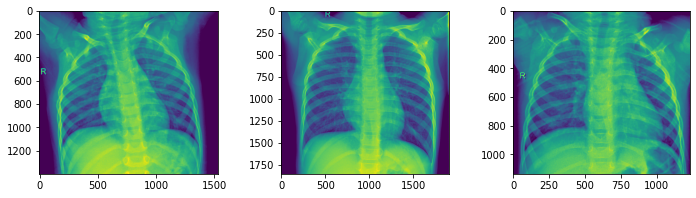

In [ ]:
import os
train_normal ="/content/chest-xray-pneumonia/chest_xray/train/NORMAL"
import matplotlib.image as mpimg

#Flow through directories and extract the image 
normal_img = [os.path.join(train_normal, file)
              for file in os.listdir(train_normal)[:3]]
plt.figure(figsize=(12, 3))
for i, img_path in enumerate(normal_img):
    sp = plt.subplot(1, 3, i+1) #Make subplots for every i images
    img = mpimg.imread(img_path)
    plt.imshow(img)

# Loading the dataset
Loading the images from directorys using the image_dataset_from_directory function from Keras.

we scale the image to size of (180,180), this function returns a tensor batch dataset of the image with a batch size of 32

with this function we also convert the image into gray scale, the reason for that is because this image are X-ray images so in this cases the color channel doesn't have much relevant than other features like blank intensity changes and edge detection.

In [ ]:
batch_size = 32
train_img = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/chest-xray-pneumonia/chest_xray/train",
    labels="inferred",
    label_mode="binary",
    color_mode="grayscale",
    batch_size=batch_size,
    image_size=(180, 180),
    seed=123,
    validation_split=0.2,
    subset="training",
    interpolation="bilinear"
)
test_img = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/chest-xray-pneumonia/chest_xray/train",
    labels="inferred",
    label_mode="binary",
    color_mode="grayscale",
    batch_size=batch_size,
    image_size=(180, 180),
    seed=123,
    validation_split=0.2,
    subset="validation",
    interpolation="bilinear"
)


Found 5216 files belonging to 2 classes.
Using 4173 files for training.
Found 5216 files belonging to 2 classes.
Using 1043 files for validation.


In [ ]:
for image_batch, labels_batch in test_img:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 1)
(32, 1)


In [ ]:
#function to plot the performance 

def performance_plot(history):
  #convert history object to dataframe
  
  fig = plt.figure(figsize = (10,5))
  fig.add_subplot(1,2,1)
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.xlabel('epochs')
  plt.ylabel('Accuracy') 
  #Loss vs epochs
  fig.add_subplot(1,2,2)
  plt.xlabel('epochs')
  plt.ylabel('Loss')
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.show()

# Optimization of memory and batch size for the training process 
In this section we apply an optimizacion to the amount of data flowing from the directories to the model per epochs, in this case we use caches and prefetch function to avoid bottle throat when fitting our model.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_img = train_img.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_img = test_img.cache().prefetch(buffer_size=AUTOTUNE)

# Building the model
In this section we build our model, I apply  convolution filter each witha feature maps of 32 and a kernel of 5x5, each convolution have a respective Max pooling to make our model have more balance in his dimensionality

the next part of the model is the compilation, in this case we applying the Adam optimizer beauces our problem is binary clasification, in this case we a learning rate of 0.001

the next one is the loss, in this case I use BinaryCrossentropy with a label smooothing of 0.0

the last one is the metrics, in this case I use the BinaryAccuracy function of keras in which a use a threshold of judgmnet of 0.7

In [ ]:
from keras.layers.pooling import AveragePooling2D

adam = tf.keras.optimizers.Adam(learning_rate = 0.001)

def cnn_model():
  Model = Sequential()
  Model.add(tf.keras.layers.Rescaling(1./255))

  Model.add(Conv2D(32,(3,3), padding = 'same', input_shape = (180, 180, 1),activation = 'relu' ))
  Model.add(MaxPooling2D( pool_size = (2,2), padding = 'same', strides=(2, 2)))
  Model.add(Dropout(0.2))

  Model.add(Conv2D(64,(3,3), activation = 'relu',kernel_regularizer =tf.keras.regularizers.l2( l=0.01)))
  Model.add(MaxPooling2D( pool_size = (2,2), padding = 'same', strides=(2, 2)))
  Model.add(Dropout(0.2))

  Model.add(Conv2D(128,(3,3), activation = 'relu', kernel_regularizer =tf.keras.regularizers.l2( l=0.01) ))
  Model.add(MaxPooling2D( pool_size = (2,2), padding = 'same', strides=(2, 2)))
  Model.add(Dropout(0.2))

  Model.add(Flatten())
  Model.add(Dense(256, activation = 'relu'))
  Model.add(Dense(1))
  Model.compile(optimizer= adam ,loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])
  return Model

# Fitting the model and start the training
In this section before start the training, I applying a early stop callback  to reduce overfitting without compromising on model accuracy with a patience of 5 

Epoch 1/50
131/131 - 6s - loss: 1.1251 - accuracy: 0.7932 - val_loss: 0.5497 - val_accuracy: 0.9425 - 6s/epoch - 47ms/step
Epoch 2/50
131/131 - 5s - loss: 0.4393 - accuracy: 0.9286 - val_loss: 0.3300 - val_accuracy: 0.9300 - 5s/epoch - 40ms/step
Epoch 3/50
131/131 - 5s - loss: 0.2642 - accuracy: 0.9504 - val_loss: 0.2613 - val_accuracy: 0.9406 - 5s/epoch - 40ms/step
Epoch 4/50
131/131 - 5s - loss: 0.2091 - accuracy: 0.9487 - val_loss: 0.1478 - val_accuracy: 0.9655 - 5s/epoch - 40ms/step
Epoch 5/50
131/131 - 5s - loss: 0.1467 - accuracy: 0.9614 - val_loss: 0.1224 - val_accuracy: 0.9684 - 5s/epoch - 40ms/step
Epoch 6/50
131/131 - 5s - loss: 0.1282 - accuracy: 0.9636 - val_loss: 0.1026 - val_accuracy: 0.9712 - 5s/epoch - 40ms/step
Epoch 7/50
131/131 - 5s - loss: 0.1251 - accuracy: 0.9614 - val_loss: 0.0966 - val_accuracy: 0.9770 - 5s/epoch - 40ms/step
Epoch 8/50
131/131 - 5s - loss: 0.1062 - accuracy: 0.9676 - val_loss: 0.1141 - val_accuracy: 0.9636 - 5s/epoch - 40ms/step
Epoch 9/50
131/1

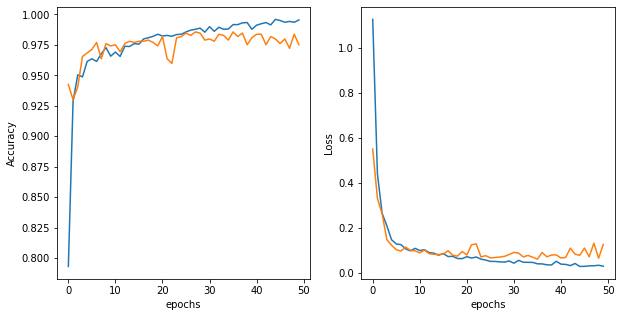

In [ ]:
from keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor = 'val_loss', mode='min', verbose=1,patience=5)
model = cnn_model()
history  = model.fit(train_img, validation_data=test_img, epochs = 50, verbose=2)
performance_plot(history)

# Evaluating performance 
After training the model I analyse his performance by plotting the accuracy adn loss per epochs for both, the training and the validation set.

In this first iteration we see a slighly good performance using a pooling technique of MaxPooling2D and with a learning rate of 0.003 

but we can still make the performance more stable and the graph smoother so we applied more strides and making the learning rate to 0.001.

After another evaluation we see improvement on the model, but the validation loss start to diverge after the 30 epochs so we apply l2 regularization to see how this could improve the results.

Finally after the regularization we could stable the model and avoid the divergence of the validation loss, in this case the final results was: 

*   Training accuracy: 99.54%
*   Validation accuracy: 98.80%




